# Image Segmentation using Tensorflow

Here we are going to be dealing with the Oxford IIIT Pets Dataset. In addition, the image is normalized to [0,1] and also perform augmentation on the image. In this segmentation task, we will be classifying the pixels in the image in three classes:

1. The pixels belonging to the pet animal.
2. The pixles surrounding the animal.
3. The pixels otherwise.

## Importing packages

In [2]:
!pip install -q git+https://github.com/tensorflow/examples.git
!pip install -qU tfds-nightly

     |████████████████████████████████| 3.6MB 3.5MB/s 


In [3]:
import tensorflow as tf
from tensorflow_examples.models.pix2pix import pix2pix
import tensorflow_datasets as tfds
from IPython.display import clear_output
import matplotlib.pyplot as plt

## Downloading the dataset

In [30]:
dataset, metadata = tfds.load('oxford_iiit_pet:3.*.*', with_info=True)

## Preparing the dataset

In [5]:
def normalize(input_image, input_mask):
    input_image = tf.cast(input_image, tf.float32) / 255.0
    input_mask -= 1
    return input_image, input_mask

In [6]:
@tf.function
def load_image_train(datapoint):
    input_image = tf.image.resize(datapoint['image'], (128,128))
    input_mask = tf.image.resize(datapoint['segmentation_mask'], (128,128))

    if tf.random.uniform(()) > 0.5:
        input_image = tf.image.flip_left_right(input_image)
        input_mask = tf.image.flip_left_right(input_mask)
    
    input_image, input_mask = normalize(input_image, input_mask)

    return input_image, input_mask

In [7]:
def load_image_test(datapoint):
    input_image = tf.image.resize(datapoint['image'], (128,128))
    input_mask = tf.image.resize(datapoint['segmentation_mask'], (128,128))

    input_image, input_mask = normalize(input_image, input_mask)

    return input_image, input_mask

The dataset is already split into training and testing data so we will be using that

In [31]:
TRAIN_LENGTH = metadata.splits['train'].num_examples
BATCH_SIZE = 64
BUFFER_SIZE = 1000
STEPS_PER_EPOCH = TRAIN_LENGTH // BATCH_SIZE

In [9]:
train = dataset['train'].map(load_image_train, num_parallel_calls = tf.data.experimental.AUTOTUNE)
test = dataset['test'].map(load_image_test)

In [10]:
train_dataset = train.cache().shuffle(BUFFER_SIZE).batch(BATCH_SIZE).repeat()
train_dataset = train_dataset.prefetch(buffer_size=tf.data.experimental.AUTOTUNE)
test_dataset = test.batch(BATCH_SIZE)

## Visualizing the dataset

In [11]:
def display(display_list):
    plt.figure(figsize=(15, 15))

    title = ['Input Image', 'True Mask', 'Predicted Mask']

    for i in range(len(display_list)):
        plt.subplot(1, len(display_list), i+1)
        plt.title(title[i])
        plt.imshow(tf.keras.preprocessing.image.array_to_img(display_list[i]))
        plt.axis('off')
    plt.show()

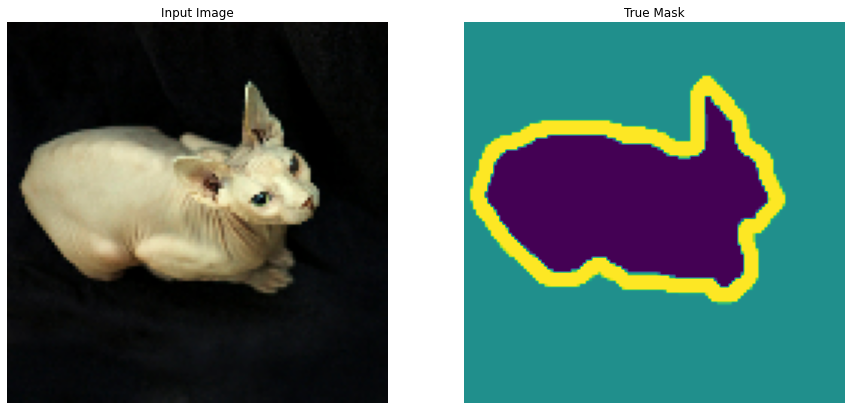

In [12]:
for image, mask in train.take(1):
    sample_image, sample_mask = image, mask
display([sample_image, sample_mask])

## Defining the model

Here, we are going to be using a U-Net as our architecture. The U-Net is an encoder decoder structure. We are going to be using the pretrained MobileNetv2 network after changing the head as the feature extractor (encoder). Our decoder will be an already implemented upsampler available in the Pix2Pix utility site. (available at Tensorflow Examples)

We are using 3 channels here to accomodate for the 3 posssible labels the pixels of the image can have.

In [13]:
OUTPUT_CHANNELS = 3

In [15]:
base_model = tf.keras.applications.MobileNetV2(input_shape=[128,128,3], include_top=False)

# using the weights and activations of the necessary layers
layer_names = [
               'block_1_expand_relu',
               'block_3_expand_relu',
               'block_6_expand_relu',
               'block_13_expand_relu',
               'block_16_project'
]

layers = [base_model.get_layer(name).output for name in layer_names]

# Create the feature extraction model
down_stack = tf.keras.Model(inputs=base_model.input, outputs=layers)

down_stack.trainable = False

In [16]:
up_stack = [
            pix2pix.upsample(512, 3),
            pix2pix.upsample(256, 3),
            pix2pix.upsample(128, 3),
            pix2pix.upsample(64, 3),
]

In [21]:
def unet_model(output_channels):
    inputs = tf.keras.layers.Input(shape=[128,128,3])
    x = inputs

    # downsampling through the model
    skips = down_stack(x)
    x = skips[-1]
    skips = reversed(skips[:-1])

    # upsampling and establishing the skip connections
    for up, skip in zip(up_stack, skips):
        x = up(x)
        concat = tf.keras.layers.Concatenate()
        x = concat([x,skip])
    
    # last layer of the model
    last = tf.keras.layers.Conv2DTranspose(
        output_channels, 3, strides=2, padding='same'
    )

    x = last(x)

    return tf.keras.Model(inputs=inputs, outputs=x)

## Training the model

In [23]:
model = unet_model(OUTPUT_CHANNELS)
model.compile(optimizer='adam', loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True), metrics=['accuracy'])

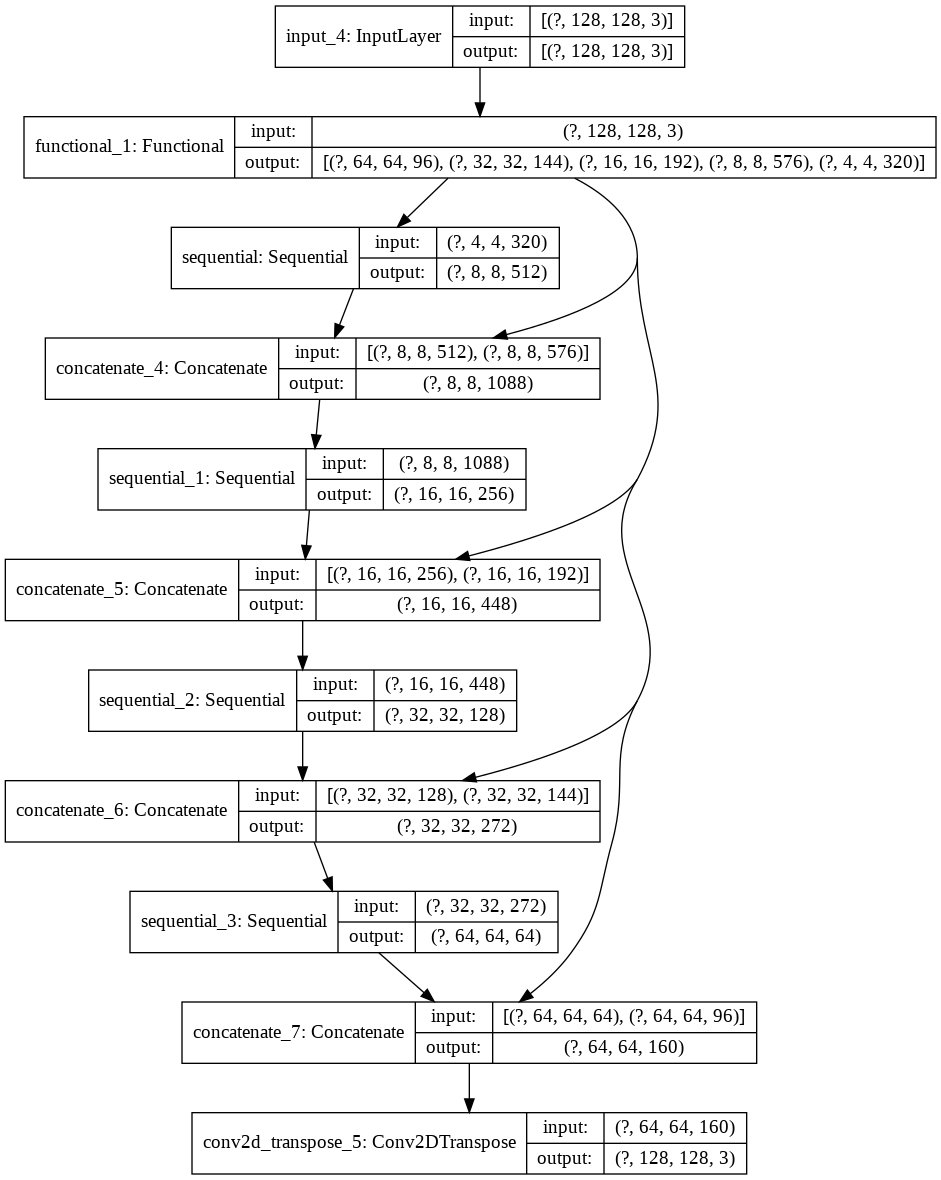

In [24]:
tf.keras.utils.plot_model(model, show_shapes=True)

Trying it out before training

In [25]:
def create_mask(pred_mask):
    pred_mask = tf.argmax(pred_mask, axis=-1)
    pred_mask = pred_mask[..., tf.newaxis]
    return pred_mask[0]

In [26]:
def show_prediction(dataset=None, num=1):
    if dataset:
        for image, mask in dataset.take(num):
            pred_mask = model.predict(image)
            display([image[0], mask[0], create_mask(pred_mask)])
    else:
        display([sample_image, sample_mask, create_mask(model.predict(sample_image[tf.newaxis, ...]))])

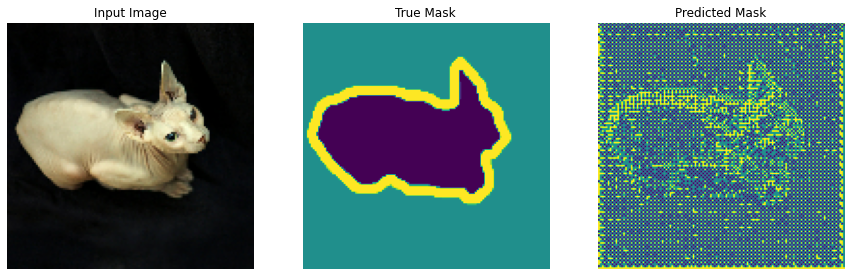

In [27]:
show_prediction()

In [28]:
class DisplayCallback(tf.keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs=None):
        clear_output(wait=True)
        show_prediction()
        print('\nSample Prediction after Epoch {}\n'.format(epoch+1))

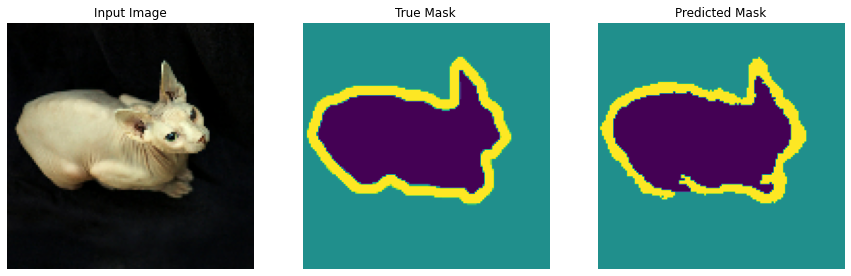


Sample Prediction after Epoch 20

57/57 [==============================] - 16s 281ms/step - loss: 0.1366 - accuracy: 0.9377 - val_loss: 0.3163 - val_accuracy: 0.8914


In [32]:
EPOCHS = 20
VAL_SUBSPLITS = 5
VALIDATION_STEPS = metadata.splits['test'].num_examples//BATCH_SIZE//VAL_SUBSPLITS

model_history = model.fit(train_dataset, epochs=EPOCHS, steps_per_epoch=STEPS_PER_EPOCH, 
                          validation_steps=VALIDATION_STEPS, validation_data=test_dataset, callbacks=[DisplayCallback()])

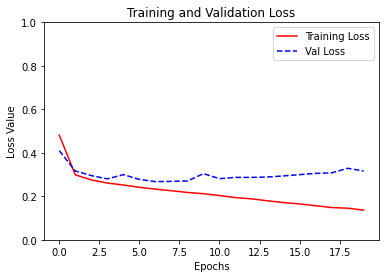

In [35]:
loss = model_history.history['loss']
val_loss = model_history.history['val_loss']

epochs = range(EPOCHS)

plt.figure()
plt.plot(epochs, loss, 'r', label='Training Loss')
plt.plot(epochs, val_loss, 'b--', label='Val Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss Value')
plt.ylim([0,1])
plt.legend()
plt.show()

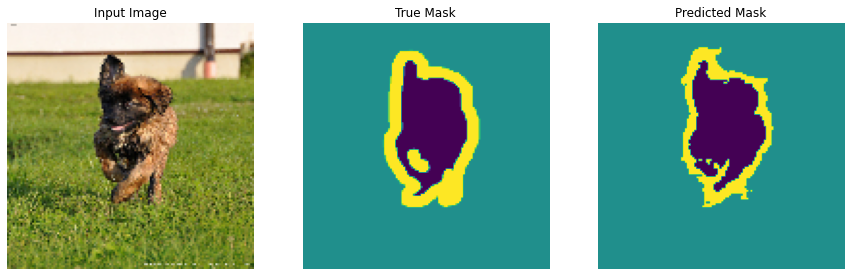

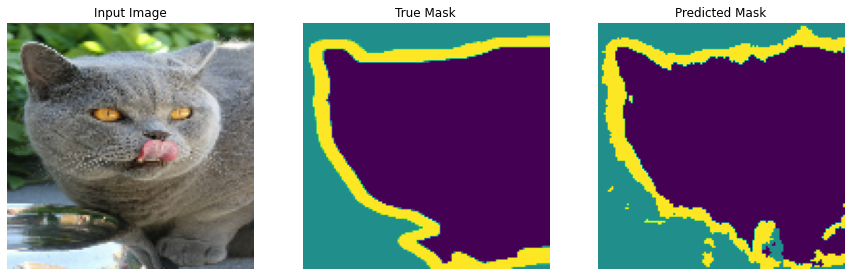

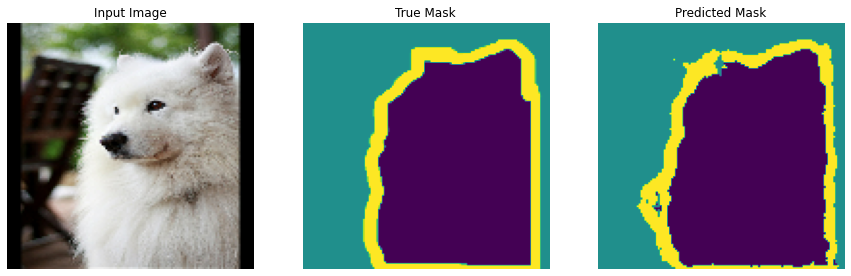

In [36]:
show_prediction(test_dataset, 3)